In [14]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt

In [15]:
file_loc = 'SPY_5min_2022-01-03T09.00.00_2022-03-25T14.10.00.csv'
df = pd.read_csv(os.path.join('data',file_loc),parse_dates=['datetime'])
df.head()

,datetime,volume,volume_weighted,open,close,high,low,timestamp,no_transactions
0,2022-01-03 09:00:00,9426.0,476.6581,476.38,476.56,476.92,476.38,1641200400000,115
1,2022-01-03 09:05:00,1778.0,476.4585,476.48,476.44,476.49,476.44,1641200700000,37
2,2022-01-03 09:10:00,9767.0,476.7624,476.62,476.83,476.87,476.58,1641201000000,80
3,2022-01-03 09:15:00,1743.0,476.7269,476.84,476.53,476.84,476.53,1641201300000,44
4,2022-01-03 09:20:00,1037.0,476.7011,476.65,476.82,476.82,476.62,1641201600000,21


In [16]:
df['time-delta'] = df['datetime'].diff().dt.seconds
for col in ['close']:
    df[f'{col}_diff'] = df[col].pct_change()
df.head()

,datetime,volume,volume_weighted,open,close,high,low,timestamp,no_transactions,time-delta,close_diff
0,2022-01-03 09:00:00,9426.0,476.6581,476.38,476.56,476.92,476.38,1641200400000,115,NaN,NaN
1,2022-01-03 09:05:00,1778.0,476.4585,476.48,476.44,476.49,476.44,1641200700000,37,300.0,-0.000252
2,2022-01-03 09:10:00,9767.0,476.7624,476.62,476.83,476.87,476.58,1641201000000,80,300.0,0.000819
3,2022-01-03 09:15:00,1743.0,476.7269,476.84,476.53,476.84,476.53,1641201300000,44,300.0,-0.000629
4,2022-01-03 09:20:00,1037.0,476.7011,476.65,476.82,476.82,476.62,1641201600000,21,300.0,0.000609


<AxesSubplot:xlabel='datetime'>

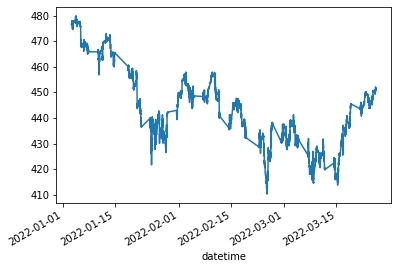

In [17]:
df.set_index('datetime')['close'].plot()

In [18]:
# Window of data we're working with
N = df.shape[0]
print(f'{N} ticks found')

# 2 hour lookback period
LOOKBACK = 2*(60/5)

# Growth requirement
GROWTH_LIMIT = 0.005

# outcome period 30min
HORIZON = 6

X = list()
y = list()

t =1
finish = False
counter = 0
while finish is False:
    
    counter+=1
    print(f'Counter:{counter}',end='\r')
    
    # check we have enough lookback data
    if t<22:
        t+=1
        continue
    
    # check we don't have enough data left then end the cycle
    if (N - t)<5:
        finish = True
        t+=1
        continue
        
    lookback_data = df.loc[t-20:t,['volume','close','open','high','low']].values
    lookback_data = lookback_data/lookback_data[-1]
    outcome_data = df.loc[t+1:t+6,'close_diff'].sum()>GROWTH_LIMIT
    
    X.append(lookback_data)
    y.append(outcome_data)
    
    t+=1

10965 ticks found


In [19]:
y = np.array(y).reshape(-1,1)
y.shape

(10939, 1)

In [20]:
X = np.stack(X)
X.shape

(10939, 21, 5)

In [21]:
X_train = X[:6000]
X_test = X[6000:]

y_train = y[:6000]
y_test = y[6000:]

# with open('./data/X_train_2.npy','wb') as f:
#     np.save(f,X_train)
    
# with open('./data/X_test_2.npy','wb') as f:
#     np.save(f,X_test)
    
# with open('./data/y_train_2.npy','wb') as f:
#     np.save(f,y_train)
    
# with open('./data/y_test_2.npy','wb') as f:
#     np.save(f,X_test)

# Defining a simple CNN

In [22]:
import tensorflow as tf
from tensorflow import keras

In [23]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

In [24]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(X_train.shape[1],X_train.shape[2])),
    keras.layers.Dense(30,activation='relu'),
    keras.layers.Dense(10,activation='relu'),
    keras.layers.Dense(1,activation='sigmoid',)
])

2022-07-31 18:28:04.485402: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-31 18:28:04.485976: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 10. Tune using inter_op_parallelism_threads for best performance.


In [25]:
metrics = [
    tf.metrics.AUC(name='auc')
]

model.compile(optimizer=keras.optimizers.Adam(1e-4),loss='binary_crossentropy',metrics=metrics)

In [26]:
callbacks = [keras.callbacks.EarlyStopping(patience=500,restore_best_weights=True)]

In [27]:
history = model.fit(X_train,y_train,batch_size=50,epochs=100,verbose=2,validation_data=(X_test,y_test))

Train on 6000 samples, validate on 4939 samples
Epoch 1/100
6000/6000 - 1s - loss: 0.2605 - auc: 0.5718 - val_loss: 0.1701 - val_auc: 0.6266
Epoch 2/100
6000/6000 - 1s - loss: 0.1863 - auc: 0.6140 - val_loss: 0.1632 - val_auc: 0.6221
Epoch 3/100
6000/6000 - 1s - loss: 0.1799 - auc: 0.6016 - val_loss: 0.1628 - val_auc: 0.6211
Epoch 4/100
6000/6000 - 1s - loss: 0.1764 - auc: 0.6029 - val_loss: 0.1627 - val_auc: 0.6202
Epoch 5/100
6000/6000 - 1s - loss: 0.1736 - auc: 0.6050 - val_loss: 0.1618 - val_auc: 0.6249
Epoch 6/100
6000/6000 - 1s - loss: 0.1710 - auc: 0.5999 - val_loss: 0.1616 - val_auc: 0.6275
Epoch 7/100
6000/6000 - 1s - loss: 0.1684 - auc: 0.6032 - val_loss: 0.1613 - val_auc: 0.6284
Epoch 8/100
6000/6000 - 1s - loss: 0.1667 - auc: 0.6001 - val_loss: 0.1614 - val_auc: 0.6278
Epoch 9/100
6000/6000 - 1s - loss: 0.1654 - auc: 0.6058 - val_loss: 0.1606 - val_auc: 0.6322
Epoch 10/100
6000/6000 - 1s - loss: 0.1636 - auc: 0.6049 - val_loss: 0.1600 - val_auc: 0.6288
Epoch 11/100
6000/600

Epoch 88/100
6000/6000 - 1s - loss: 0.1248 - auc: 0.7065 - val_loss: 0.1592 - val_auc: 0.6406
Epoch 89/100
6000/6000 - 1s - loss: 0.1246 - auc: 0.7181 - val_loss: 0.1594 - val_auc: 0.6418
Epoch 90/100
6000/6000 - 1s - loss: 0.1245 - auc: 0.7133 - val_loss: 0.1601 - val_auc: 0.6475
Epoch 91/100
6000/6000 - 1s - loss: 0.1244 - auc: 0.7175 - val_loss: 0.1592 - val_auc: 0.6473
Epoch 92/100
6000/6000 - 1s - loss: 0.1245 - auc: 0.7077 - val_loss: 0.1598 - val_auc: 0.6573
Epoch 93/100
6000/6000 - 1s - loss: 0.1244 - auc: 0.7134 - val_loss: 0.1596 - val_auc: 0.6430
Epoch 94/100
6000/6000 - 1s - loss: 0.1242 - auc: 0.7095 - val_loss: 0.1598 - val_auc: 0.6481
Epoch 95/100
6000/6000 - 1s - loss: 0.1242 - auc: 0.7131 - val_loss: 0.1606 - val_auc: 0.6496
Epoch 96/100
6000/6000 - 1s - loss: 0.1242 - auc: 0.7089 - val_loss: 0.1594 - val_auc: 0.6478
Epoch 97/100
6000/6000 - 1s - loss: 0.1241 - auc: 0.7157 - val_loss: 0.1596 - val_auc: 0.6453
Epoch 98/100
6000/6000 - 1s - loss: 0.1240 - auc: 0.7167 - v

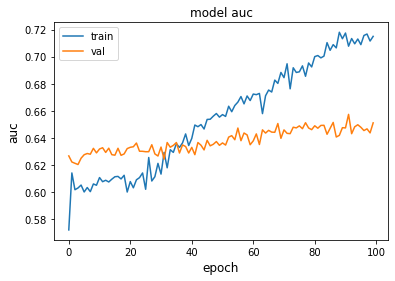

In [28]:
from matplotlib import pyplot as plt
metric = 'auc'
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history['val_'+metric])
plt.title('model '+metric)
plt.ylabel(metric,fontsize='large')
plt.xlabel('epoch',fontsize='large')
plt.legend(['train','val'],loc='best')
plt.show()